# DC Resistivity Part 2

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This example examines the distribution of charges and the behaviour of currents for a DC experiment where one end of an electrode is connected to a finite length well (follows [Kaufman and Wightman (1993)](https://doi.org/10.1190/1.1443388). This notebook was used to produce Figure 6 in Heagy and Oldenburg (2018)

If you encounter problems when running this notebook, please [open an issue](https://github.com/simpeg-research/heagy_2018_emcyl/issues). 

## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them. 

In [1]:
# !pip install -r ../requirements.txt

In [2]:
# core python packages
import time
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0
import ipywidgets

# SimPEG and discretize packages
from SimPEG.EM import TDEM
from SimPEG import Utils, Maps
import discretize
from discretize import utils
from pymatsolver import Pardiso

# utilities for running simulations with steel cased wells
import casingSimulations as casingSim


%matplotlib inline

##  Parameters

In [3]:
simDir = 'DC_Kaufman_finite_well'  # create a simulation directory where results can be saved. 

In [4]:
casing_l = np.r_[250, 500, 1000, 2000, 4000]

### model parameters

The small function `get_model` is used to create a model given a casing length. The source will be located along the $\theta = 90^{\circ}$ line 

In [5]:
sigma_casing = 1e6 # conductivity of the casing
sigma_back = 1e-2 # conductivity of the background
casing_t = 10e-3 # 10mm thick casing
casing_d = 100e-3 # 10cm diameter

def get_model(casing_l):
    """
    create a model object provided a casing length
    """
    model = casingSim.model.CasingInHalfspace(
        directory = simDir,
        sigma_casing = sigma_casing,  # conductivity of the casing (S/m)
        sigma_back = sigma_back,  # conductivity of the background (S/m)
        sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
        casing_d = casing_d-casing_t,  # 135mm is outer casing diameter
        casing_l = casing_l,
        casing_t = casing_t, 
    )

    # adjust the src_a location so it is connected to well
    model.src_a = np.r_[model.casing_r, np.pi/2., -1.25] 
    model.src_b = np.r_[2*casing_l.max(), np.pi/2., -1.25]
    
    return model

To keep track of the models, we will store the in a dictionary, `model_dict`

In [6]:
model_dict = {}
model_names = []
for l in casing_l:
    mod = get_model(l)
    name = "model_{}".format(l)
    model_names += [name]
    model_dict[name] = mod
model_dict

{'model_1000': <casingSimulations.model.CasingInHalfspace at 0x1100ba110>,
 'model_2000': <casingSimulations.model.CasingInHalfspace at 0x1100ba150>,
 'model_250': <casingSimulations.model.CasingInHalfspace at 0x1100ba0d0>,
 'model_4000': <casingSimulations.model.CasingInHalfspace at 0x1100ba190>,
 'model_500': <casingSimulations.model.CasingInHalfspace at 0x103fd7fd0>}

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [7]:
# parameters defining the core region of the mesh
csx2 = 25. # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 100  # go out 500m from the well

# padding parameters
npadx, npadz = 16, 23  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# theta discretization
hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
def get_mesh(mod):
    return casingSim.CasingMeshGenerator(
        directory=simDir,  # directory where we can save things
        modelParameters=mod,  # casing parameters
        npadx=npadx,  # number of padding cells in the x-direction
        npadz=npadz,  # number of padding cells in the z-direction
        domain_x=domainx2,  # extent of the second uniform region of the mesh 
        hy=hy,   # cell spacings in the 
        csx1=mod.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
        csx2=csx2,  # second core cell size
        csz=csz,  # cell size in the z-direction
        pfx2=pfx2,  # padding factor to "infinity"
        pfz=pfz  # padding factor to "infinity" for the z-direction
    )

Since each model has a different casing length, we will create a different mesh for each model and store them in a dictionary

In [8]:
mesh_dict = {
    key: get_mesh(mod) for key, mod in model_dict.items()
}

Plot all of the meshes

[[<matplotlib.axes._subplots.PolarAxesSubplot at 0x1100ba510>,

/anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


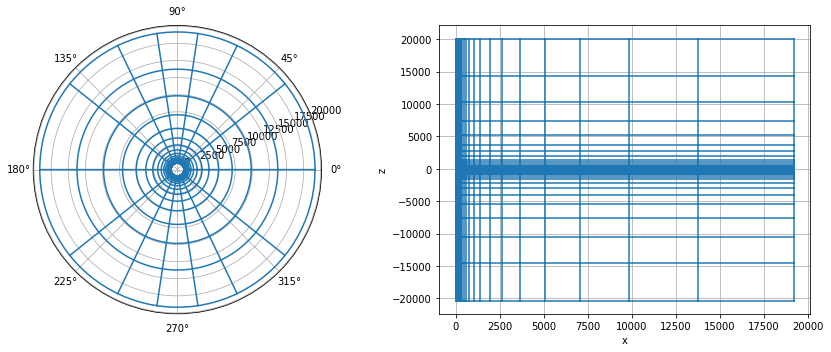

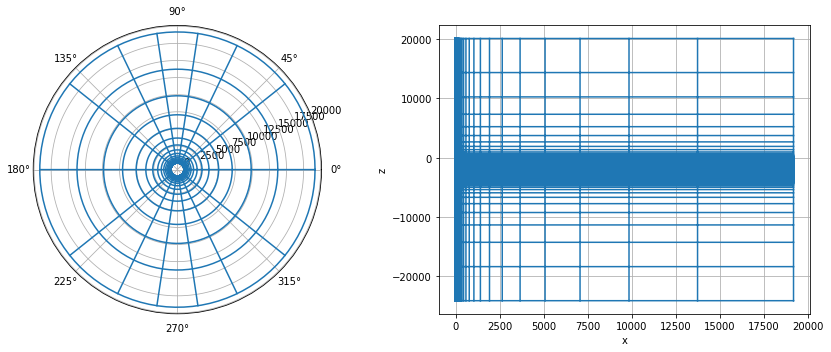

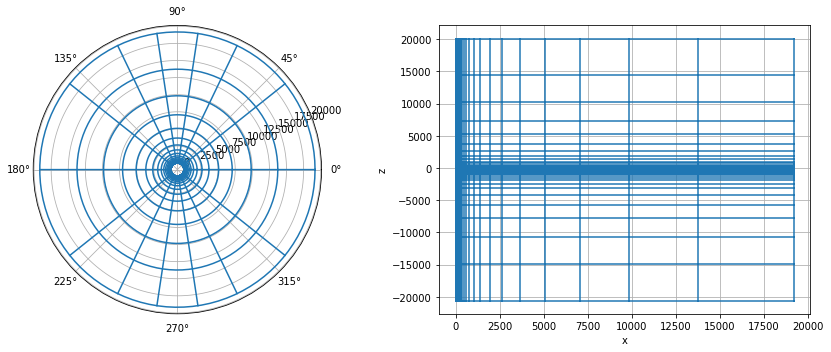

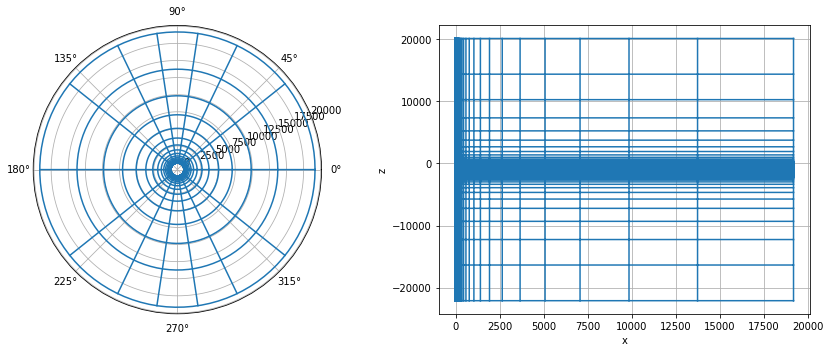

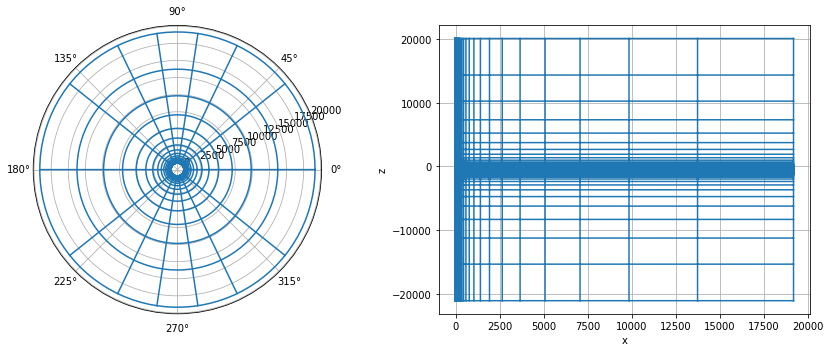

In [9]:
[meshGen.mesh.plotGrid() for meshGen in mesh_dict.values()]

In [10]:
for key in model_names: 
    print(
        "{}:  {} cells in the mesh".format(key + " " if len(key)<10 else key, mesh_dict[key].mesh.nC)
    )

model_250 :  168168 cells in the mesh
model_500 :  275968 cells in the mesh
model_1000:  491568 cells in the mesh
model_2000:  922768 cells in the mesh
model_4000:  1785168 cells in the mesh


## Physical property models

Now that we have defined the mesh and model parameters, we can populate the mesh with physical properties. 

In [11]:
# Assign physical properties on the mesh
physpropsDict = {
    name: casingSim.model.PhysicalProperties(mesh_dict[name], mod) 
    for name, mod in model_dict.items()
}

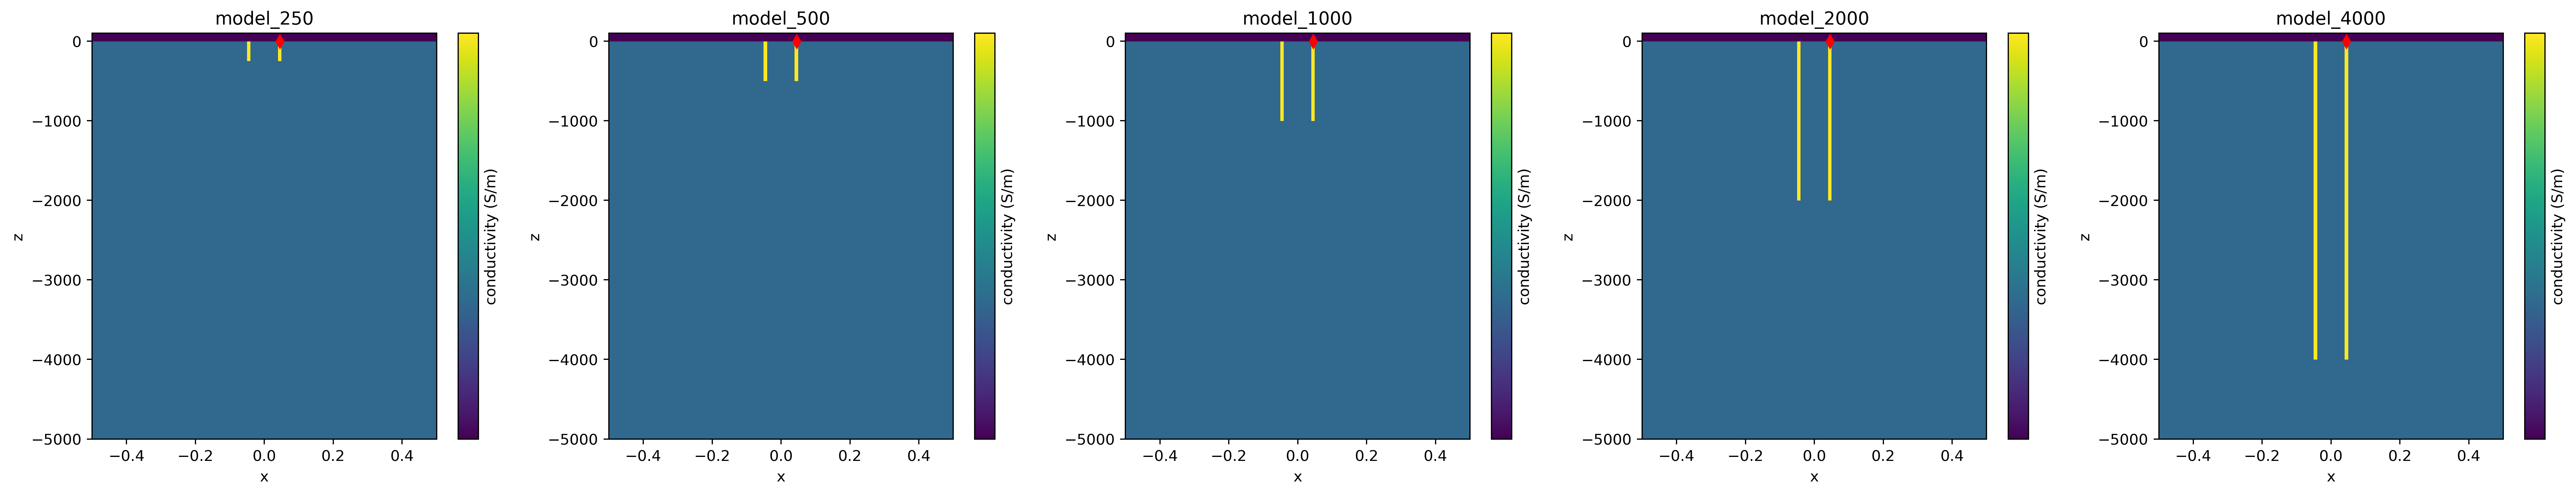

In [12]:
# Plot the models and source location

symbols = ['rd', 'ws', 'k>', 'mo', 'c*', 'C3s']

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)

for key, a in zip(model_names, ax):
    # cylMeshGen.mesh.plotGrid(ax=ax, slice='theta')
    a, cb = physpropsDict[key].plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )

    cb.set_label('conductivity (S/m)')

    a.set_title(key)

    model = model_dict[key]
    a.plot(model.src_a[0], model.src_a[2], symbols[0])
    a.plot(model.src_b[0], model.src_b[2], symbols[0])

    a.set_xlim(0.5*np.r_[-1, 1]) #src_b[:, 0].max()])
    a.set_ylim([ -1.25*casing_l.max(), 100])


## set up a DC simulation for each model

In [13]:
simDict = {}
for key in model_names:
    simDict[key] = casingSim.run.SimulationDC(
        modelParameters=model_dict[key], directory=simDir, 
        meshGenerator=mesh_dict[key], 
        src_a=model_dict[key].src_a, src_b=model_dict[key].src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


## Run the DC simulations

In [14]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run(save=False)
    print('\n')

--- Running model_250 ---
Validating parameters...
      max x: 19169.5917058, min z: -20342.4981276, max z: 20092.4981276, nC: 168168
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 6.78223896027


--- Running model_500 ---
Validating parameters...
      max x: 19169.5917058, min z: -20592.4981276, max z: 20092.4981276, nC: 275968
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 12.1124989986


--- Running model_1000 ---
Validating parameters...
      max x: 19169.5917058, min z: -21092.4981276, max z: 20092.4981276, nC: 491568
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 25.7866880894


--- Running model_2000 ---
Validating parameters...
      max x: 19169.5917058, min z: -22092.4981276, max z: 20092.4981276, nC: 922768
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 78.6181859

## Plot the casing currents

Here, we plot the computed casing currents and compare those the the end-member cases for a short well and a long well described by [Kaufman and Wightman (1993)](https://doi.org/10.1190/1.1443388). (Equations 45 and 53)

In [15]:
# from equations 45 and 53 in Kaufman and Wightman (1993)
def current_short_well(model, z):
    """
    current in a short well - decay is linear
    """
    return (1 - z/model.casing_l)

def alpha(model):
    """
    factor controlling the rate of decay in a long well
    """
    return 1./np.sqrt(
        1./model.sigma_back * model.sigma_casing * 2. * np.pi * model.casing_r * model.casing_t
    )

def current_long_well(model, z):
    """
    current in a long well - decay is exponential and depends upon the parameter alpha
    """
    return np.exp(-alpha(model) * z)

### plot currents in casing

In [20]:
src_ind=0

def plot_casing_currents(ax=None, include_transmission=True):
    """
    Plot the currents and charges along the length of the casing. If `include_transmission`
    is True, then the transmission line solutions from Kaufmann (described in the functions 
    above) are included
    """
   
    if ax is None: 
        fig, ax = plt.subplots(1, 2, figsize=(10, 4)) #, dpi=400)
    
    for i, key in enumerate(model_names):
        f = fieldsDict[key]
        src = simDict[key].survey.srcList[src_ind]
        mod = model_dict[key]
        mesh = mesh_dict[key].mesh
    
        z_currents, iz = casingSim.casing_currents(f[src, 'j'], mesh, mod)["z"]
        z_charges, charges = casingSim.casing_charges(f[src, 'charge'], mesh, mod)
        
        
        label = key.split("_")[-1] + " m"
        
        ax[0].plot(-z_currents/mod.casing_l, -iz, label=label, color="C{}".format(i))
        ax[1].plot(-z_charges/mod.casing_l, charges, label=label, color="C{}".format(i))
        
        if include_transmission is True:
            if mod.casing_l == casing_l.min():
                short_well = current_short_well(mod, -z_currents)
                ax[0].plot(-z_currents/mod.casing_l, short_well, color="k", linestyle='--')
            elif mod.casing_l == casing_l.max():
                long_well = current_long_well(mod, -z_currents)
                ax[0].plot(-z_currents/mod.casing_l, long_well, color="k".format(i), linestyle='-.')

    [a.set_xlim([1.25/mod.casing_l, 1.]) for a in ax]
    [a.legend() for a in ax]
    [a.set_xlabel('depth / casing length') for a in ax]
    [a.grid(which='both', alpha=0.4) for a in ax]

    ax[0].set_ylabel('downward-going current (A)')
    ax[1].set_ylabel('charge (C)')
    
    return ax

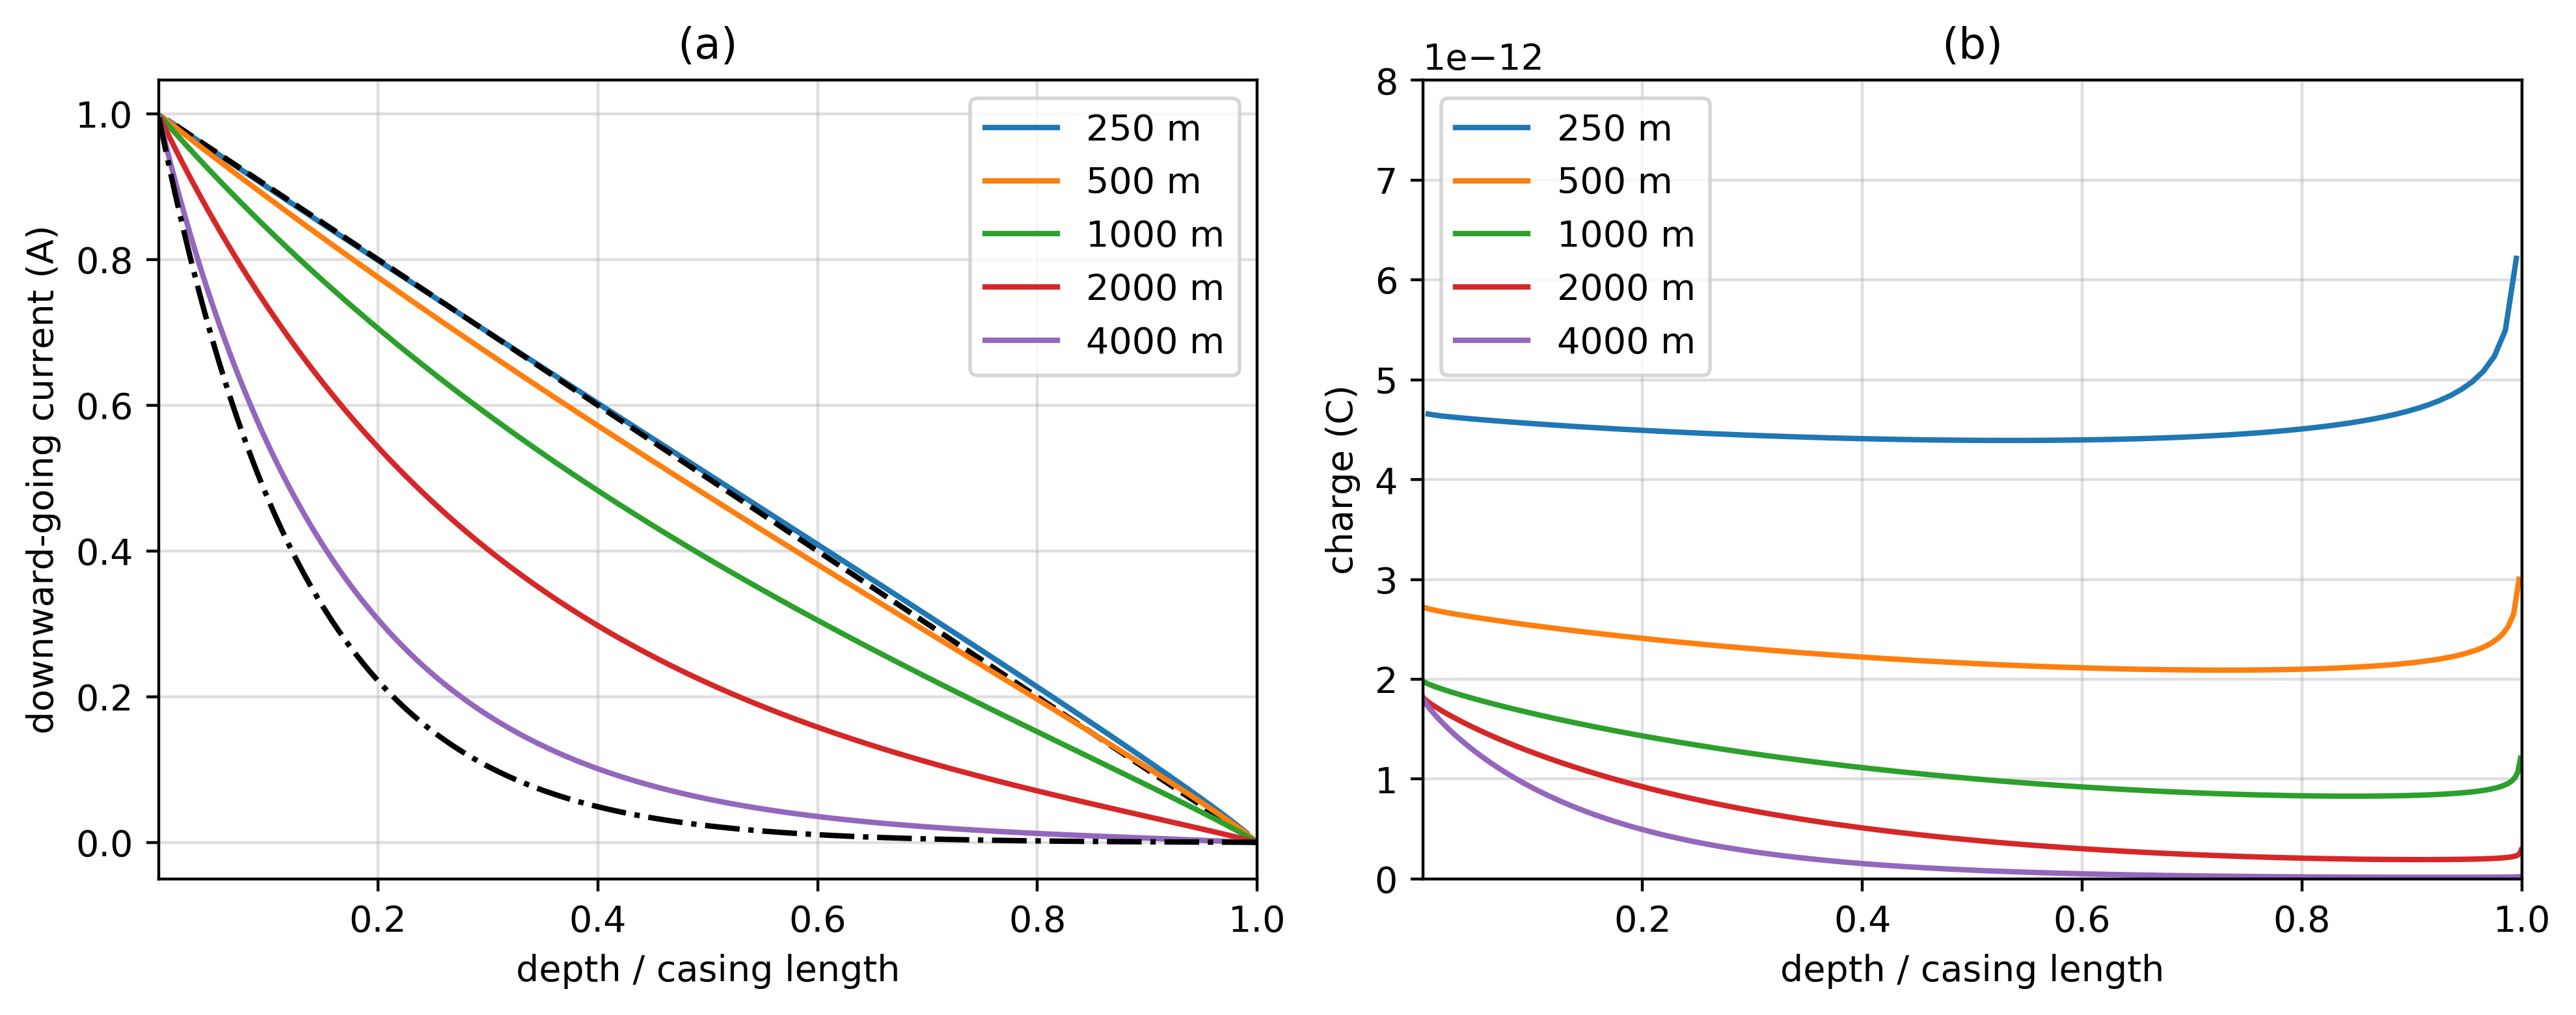

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
ax = plot_casing_currents(ax=ax)
ax[1].set_ylim(8e-12*np.r_[0, 1])
[a.set_xlim([-mod.src_a[2]/mod.casing_l, 1.]) for a in ax]

ax[0].set_title('(a)')
ax[1].set_title('(b)')

plt.tight_layout()

# fig.savefig("kaufman_finite_well")  # uncomment to save the figure

## Plotting code for the fields, fluxes and charges

This is a widget for interrogating the results. 
- `max_r`: maximum radial extent of the plot (m)
- `min_depth`: minimum depth (m)
- `max_depth`: maximum depth (m)
- `clim_min`: minimum colorbar limit. If `0`, then the colorbar limits are the plotting defaults
- `clim_max`: maximum colorbar limit. If `0`, then the colorbar limits are the plotting defaults
- `model_key`: model which we are viewing
- `view`: field or physical property that is plotted
- `theta_ind`: index of the azimthal slice that we are viewing
- `show_mesh`: if checked, the mesh will be plotted on the right hand half of the plot
- `casing_outline`: draws the outline of the casing

In [22]:
viewer = casingSim.FieldsViewer(
    sim_dict=simDict, fields_dict=fieldsDict, model_keys=model_names
)

In [23]:
viewer.widget_cross_section(
    defaults={"min_depth":0, "max_depth":casing_l.max()}, fixed={"use_aspect":False}
)

<function ipywidgets.widgets.interaction.<lambda>>